In [122]:
%matplotlib inline
from matplotlib import pyplot as plt
import zounds
import requests
from io import BytesIO

# fetch some audio of a Bach piece from Internet Archive
url = 'https://ia802606.us.archive.org/9/items/AOC11B/onclassical_luisi_bach_partita_B-flat-major_bwv-825_1.ogg'
resp = requests.get(url)
bio = BytesIO(resp.content)


# load and decode the audio samples
samples = zounds.AudioSamples.from_file(bio)
# take a slice of the first five seconds
samples = samples[:zounds.Seconds(5)]
# convert to mono
samples = samples.mono

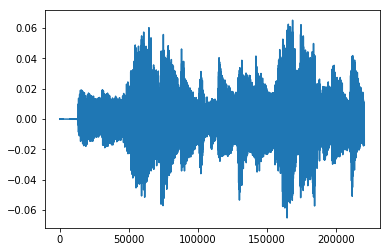

In [26]:
plt.plot(samples)
import IPython.display as ipd
ipd.Audio(samples, rate=int(samples.samplerate))

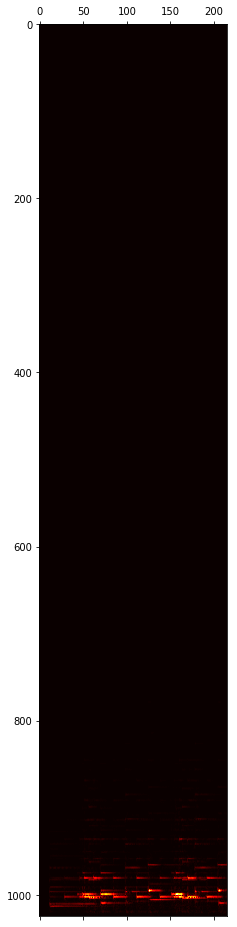

In [136]:
import numpy as np
time_frequency = zounds.spectral.stft(samples)

# time-frequency magnitudes
time_frequency = np.abs(time_frequency)

# display
time_frequency_img = np.rot90(np.array(time_frequency))
plt.matshow(time_frequency_img, cmap='hot')

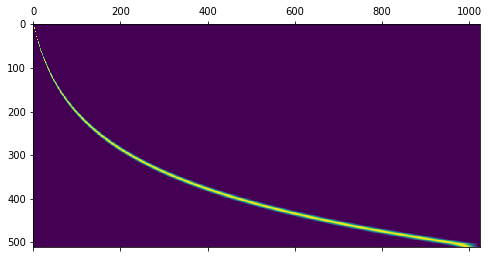

In [194]:
linear_scale = time_frequency.dimensions[-1].scale
band = zounds.FrequencyBand(20, samples.samplerate.nyquist)
n_filters = 512
scale = zounds.MelScale(band, n_filters)
mel_scale_basis = scale._basis(linear_scale, zounds.HanningWindowingFunc())
plt.matshow(mel_scale_basis)

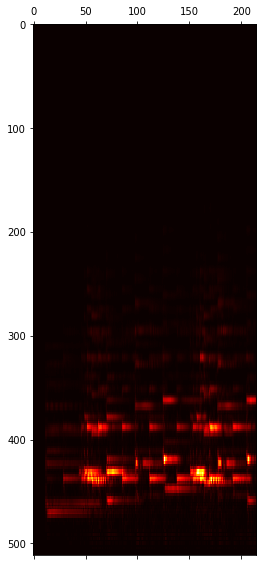

In [195]:
mel_spectrogram = scale.apply(time_frequency, zounds.HanningWindowingFunc())

# display
mel_spectrogram_img = np.rot90(np.array(mel_spectrogram))
plt.matshow(mel_spectrogram_img, cmap='hot')

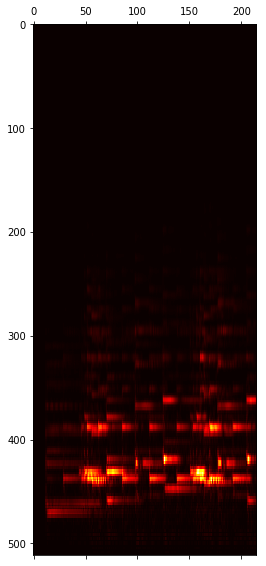

In [196]:
log_amplitude = 20 * np.log10(1 + mel_spectrogram)

# display
log_amplitude_img = np.rot90(np.array(log_amplitude))
plt.matshow(log_amplitude_img, cmap='hot')

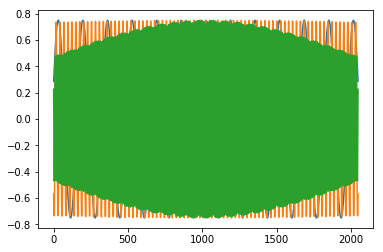

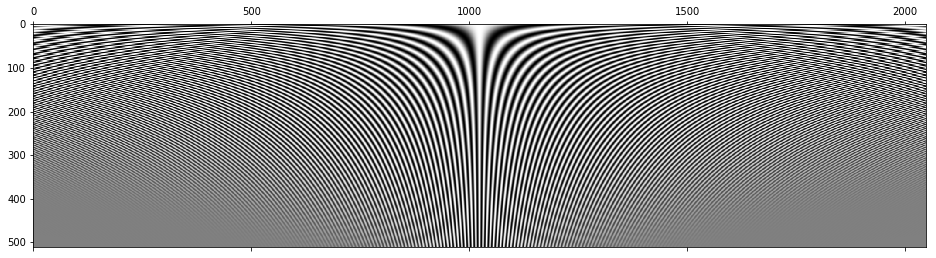

In [252]:
from scipy.signal import morlet

def make_filter_bank(samplerate, basis_size, kernel_size, scale):
    """
    Create a bank of finite impulse response filters, with 
    frequencies centered on the sub-bands of scale
    """
    basis = np.zeros((basis_size, kernel_size), dtype=np.complex128)
    
    cycles = np.geomspace(2048, 128, basis_size)
    for i, band in enumerate(scale):
        basis[i] = morlet(
            kernel_size, # wavelet size
            cycles[i], # time-frequency resolution tradeoff 
            (band.center_frequency / samplerate.nyquist)) # frequency
    return basis.real

kernel_size = 2048
complex_filter_bank = make_filter_bank(samples.samplerate, n_filters, kernel_size, scale)

filter_bank = complex_filter_bank.real
plt.plot(filter_bank[10, :])
plt.plot(filter_bank[100, :])
plt.plot(filter_bank[256, :])

plt.matshow(filter_bank, cmap='gray')

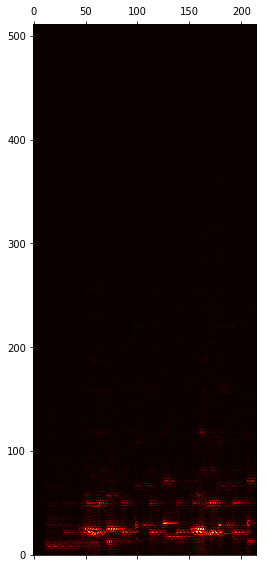

In [253]:
windowing_scheme = zounds.HalfLapped()
windowed = samples.sliding_window(windowing_scheme)
windowed *= np.hanning(windowed.shape[-1])

spectral = np.dot(complex_filter_bank, windowed.T)
spectral = np.abs(spectral)

plt.matshow(spectral, cmap='hot', origin='lower')

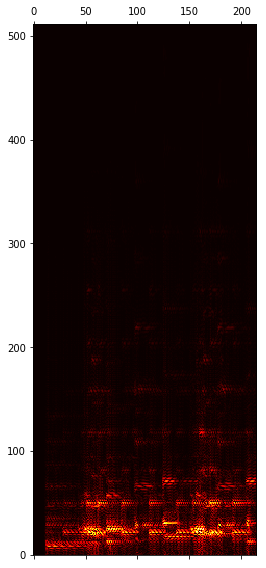

In [254]:
mel_scale_log_amplitude = 20 * np.log10(1 + spectral)
plt.matshow(mel_scale_log_amplitude, cmap='hot', origin='lower')